In [966]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

Let's first generate synthetic data 
- We are using synthetic data a it gives us full control and we can see exactly how the model works

In [967]:
# np.random.seed(42)
X = np.random.rand(100,3)
beta_true = np.array([1.5,0,-2])
y = X @ beta_true + np.random.randn(100) * 0.1
y

array([ 0.42767892, -0.19635556, -0.03129531,  0.97847725,  0.20068843,
       -1.00072194, -1.78641748, -0.59635769, -0.01060385, -0.45474965,
       -0.78722914, -0.88828768,  0.43071057,  1.00069938, -0.43644003,
       -0.5279149 ,  0.72106066, -1.68472136, -1.24938327,  0.32023077,
       -1.62891011,  0.16850994, -0.63330468,  1.15480728, -0.98129106,
       -1.27303679, -1.0208608 ,  0.54918213,  0.43987868, -0.57745047,
        0.80883741, -0.01370656, -0.32212626, -0.00876642,  0.61998421,
        1.13097332, -0.69739048,  0.61384071, -0.74595131, -0.23770248,
       -1.04161971, -0.71904935,  0.18013764, -1.89428222, -1.75700969,
       -0.34639074, -1.15539885, -0.59627163, -0.79540116, -0.42902236,
        0.67888449,  0.011398  ,  0.03547306,  0.86074543,  0.84775649,
        0.53486871,  0.94891628, -0.52474542, -0.11477715,  0.07815744,
        0.59630166,  0.17580584,  0.14111257, -1.113765  , -0.91891013,
       -0.11189806, -0.12755181,  0.96690888, -1.74867925,  0.84

We now write the lasso loss function which is basically standard linear regression with an L1 regularization parmeter
$$\ell(\beta) = \frac{1}{2n} \sum_{i=1}^n (y_i- X_i\beta)^2 + \lambda\sum_{j=1}^p |\beta_j|$$

here, our $\lambda$ parameter controls how strong our regularization will be. the higher the parameter, the more coefficints wil be forced to 0 

We will now translate this into code!!

In [968]:
def loss_fn_lasso(X,y,beta,lmbda):
    n = len(y)
    pred = X @ beta
    resid = y - pred
    l = (1/2*n)* np.sum(resid**2)+ lmbda*np.sum(np.abs(beta))
    return l 

We are now going to use gradint descent to minize the loss function, we will also be using a soft-thresholding operator to handle the L1 term

Soft thresholding is needed becaus ethe L1 penalty isnt smooth and as a result we need soft thresholding to ensure that the coeeficients are updated properly

**Definition of soft thresholding**

for a scalar input $x$ and threshold $\lambda \geq 0  $ the soft-thresholding operator $S_\lambda(x)$ is defined as: 

$$S_\lambda(x) = sign(x) \cdot \max(|x|-\lambda,0)$$

essentially, this implies that:

- if $|x| > \lambda $ the operator subtracts $\lambda$ from the aboslute value of $x$ and retains the orignal sign. e.g if $x= 5 , \lambda = 3 $ then $ S_3(5) = 1 \cdot (5-3) = 2 $
    
- if $|x| \leq \lambda $ the result is 0






In [969]:
def lasso_gd(X,y,beta, lmbda,lr,itter):
    n = len(y)
    for _ in range (itter):
        pred = X@beta
        gradient = -(1/n)*X.T @ (y-pred)
        beta = beta - lr * gradient
        # This is wher we apply the soft thresholding I mentioned above
        beta = np.sign(beta)* np. maximum(0,np.abs(beta) - lr *lmbda)
    return beta

Now we will apply these function to our data in conjunction witha cross validation method to tune our $\lambda$ paramater

In [970]:
beta_init = np.random.randn(3)
lmbda_param = 0.01
lr = 0.02
itter = 1000

beta_hat = lasso_gd(X,y,beta_init,lmbda_param,lr,itter)
beta_hat

array([ 1.02814412, -0.        , -1.50703159])

Now let's optimize our lambda parameter




In [971]:
lmbdas = [0.01,0.1,1.0,10.0,100.0]

def hyp_opt(lmbdas,X,y,beta_init,lr,itter,bt):
    Sumsqerr = lambda bt, bp : np.sum((bt - bp)**2)
    best = np.inf
    ell = 0
    for lmbda in lmbdas: 
        bp = lasso_gd(X, y, beta_init, lmbda, lr, itter)
        if Sumsqerr(bt,bp) <= best: 
            best = Sumsqerr(bt,bp)
            ell = lmbda
    return ell 

optimal = hyp_opt(lmbdas,X,y,beta_init,lr,itter,beta_true)  
print(optimal)
    




0.01


We are going to use lasso on a popular insurance dataset 
Let's predict insurance charges based on all the other predictors 

In [972]:
df = pd.read_csv("Play data/insurance.csv")
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


Let's do some encoding 

In [973]:
df_encoded = pd.get_dummies(df,columns=['region'])
df_encoded[['region_northeast', 'region_northwest', 'region_southeast', 'region_southwest']] = \
    df_encoded[['region_northeast', 'region_northwest', 'region_southeast', 'region_southwest']].astype(int)
df_encoded['smoker'] = df_encoded['smoker'].apply(lambda x: 0 if x == 'yes' else 1)
df_encoded['sex'] = df_encoded['sex'].apply(lambda x: 0 if x == 'male' else 1)
df_encoded


,age,sex,bmi,children,smoker,charges,region_northeast,region_northwest,region_southeast,region_southwest
0,19,1,27.900,0,0,16884.92400,0,0,0,1
1,18,0,33.770,1,1,1725.55230,0,0,1,0
2,28,0,33.000,3,1,4449.46200,0,0,1,0
3,33,0,22.705,0,1,21984.47061,0,1,0,0
4,32,0,28.880,0,1,3866.85520,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...
1333,50,0,30.970,3,1,10600.54830,0,1,0,0
1334,18,1,31.920,0,1,2205.98080,1,0,0,0
1335,18,1,36.850,0,1,1629.83350,0,0,1,0
1336,21,1,25.800,0,1,2007.94500,0,0,0,1


Now let's split our X and our y's 


In [974]:
X = df_encoded.drop('charges' ,axis=1)
y = df_encoded['charges']

Let's scale our data 

In [975]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

Now we split into training and testing data and also add an intercept term 


In [976]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=42)


def add_intercept(X):
    n_samples = X.shape[0]
    ones = np.ones((n_samples, 1))
    return np.hstack((ones, X))

X_train = add_intercept(X_train)
X_test = add_intercept(X_test)

X_train

array([[ 1.        ,  1.12447859,  1.0105187 , ...,  1.76548098,
        -0.61132367, -0.56641788],
       [ 1.        , -1.36756307, -0.98959079, ...,  1.76548098,
        -0.61132367, -0.56641788],
       [ 1.        ,  0.12766192, -0.98959079, ..., -0.56641788,
        -0.61132367, -0.56641788],
       ...,
       [ 1.        ,  1.33808216, -0.98959079, ..., -0.56641788,
        -0.61132367, -0.56641788],
       [ 1.        , -0.15714284,  1.0105187 , ..., -0.56641788,
        -0.61132367,  1.76548098],
       [ 1.        ,  1.12447859, -0.98959079, ..., -0.56641788,
        -0.61132367,  1.76548098]], shape=(869, 10))

In [977]:
beta_init = np.random.randn(X_train.shape[1])
lmbda_param = 0.1
lr = 0.1
itter = 1000
beta_hat = lasso_gd(X_train,y_train,beta_init,lmbda_param,lr,itter)
beta_hat


array([13218.3128092 ,  3662.19038477,   -90.36678628,  2199.93387757,
         470.41495962, -9523.02995691,   233.22107455,    86.25553174,
        -139.74017045,  -176.25297108])

In [978]:
predict = lambda x,beta: x@beta
predictions = predict(X_test,beta_hat)
predictions 

array([ 8726.55694129,  7004.26052279, 36772.48638307,  9420.8517567 ,
       27036.44180077, 11089.95295838,  -136.98582391, 17331.66285663,
         667.42913827, 11265.92094173, 27749.82025822,  9475.21554901,
        4899.03323025, 38496.77050596, 40460.11789291, 37136.52592219,
       15228.46266286, 35731.76126744,  8776.0565781 , 31296.68778397,
        3447.81773961, 10109.95978746,  2277.20843245,  7228.28626657,
       11140.22419375, 13001.04038127, 14483.47879304,  5965.74334731,
        9762.32555798,  2019.61689923,  8736.77663998, 13131.46017362,
        4328.12592887,  2976.73104315,  4348.49202483, 13406.33296108,
        1564.79375331,  8564.44919909, 33039.58709801, 32528.16085445,
        3398.72933079,  4404.82350906, 14083.46263895, 11536.66245503,
        8736.22212767, 12051.10087166,  5176.52230541,  2630.68468359,
       35412.05444408,  9167.45920366, 15795.79155032,  2132.10609848,
       12551.75388185,  1429.08618969, 13476.41011022, 12713.81338873,
      

In [979]:
r2_score(y_test,predictions)

0.7522839980933614

**Now lets do some beyesian stuff**\
What I plan on doing is running a simple linear regression in a bayesian context, first we will attempt to do it analytically and then I will try using some MCMC methods instead 

Let's do the derivation 

we assume that: 

$$y_i = \alpha + \beta x_i + \epsilon_i \text{ and   } \epsilon_i \sim N(0,\sigma^2)$$

for our conjugate priors pn our betas and the error variance, we wil be using a Normal inverse Gamma prior:

for our betas given $\sigma^2$: 
$$ (\alpha, \beta)|\sigma^2 \sim N(\theta_0,\sigma^2 \Sigma_0) $$
where $\theta_0$ is the prior mean and $\Sigma_0$ is a 2x2 covariance matrix

for the variance: 
$$\sigma^2 \sim InvGamma(a_0,b_0)$$



now, given the data y with the design matrix X, the likelihood is: 

$$p(y|\alpha, \beta , \sigma^2) \propto (\sigma^2)^{n/2} \exp \bigg(- \frac{1}{2\sigma^2}(y-X\theta)^T(y-X\theta)\bigg)  $$
with: $\theta = (\alpha,\beta)^T$

Now, when we combine tghe likelihood with the conjugate prior, it still yields a Normal invers Gamma: 
- the posterior for $\theta | \sigma^2,y $ is: 

$$
\theta | \sigma^2,y \sim N(\theta_n, \sigma^2, \Sigma_n)
$$
Where: 
$$
\Sigma_n^{-1} =  \Sigma_0^{-1} + X^TX  \text{  and  } \theta_n = \Sigma_n(\Sigma_0^{-1}\theta_0 + X^Ty)
$$

- the posterior for $\sigma^2$ is: 

$$\sigma^2|y  \sim InvGamma(a_n, b_n)
$$

With: 

$$
a_n = a_0 + n/2 \text{ and } b_n = b_0 + 1/2 \bigg(y^Ty + \theta_0^T \Sigma_0^{-1} \theta_0 - \theta_n^T \Sigma_n^{-1} \theta_n \bigg)
$$

Now let's writ some code that applies this

In [ ]:
np.random.seed(42)
n = 100
x = np.linspace(0, 10, n)
true_alpha = 1.0
true_beta = 2.0
true_sigma = 1.0
y = true_alpha + true_beta * x + np.random.normal(0, true_sigma, size=n)

#  Creating the design matrix with an intercept column included!!!! 
X = np.column_stack((np.ones(n),x))

# These are the for (alpha, beta) given sigma squared 
theta_0 = np.array([0,0])
Cov_0 = np.eye(2) * 1e6

# prior for sigma squared
a0 = 0.001
b0 = 0.001

# We now coput the posterior hyperparameters
Cov_0_inv = np.linalg.inv(Cov_0)

# Then update the covariance matrix
Cov_n_inv = Cov_0_inv + X.T @ X 
Cov_n = np.linalg.inv(Cov_n_inv)

# now we get the posterior mean for (alpha, bets)
theta_n  = Cov_n @ (Cov_0_inv @ theta_0 + X.T @ y)

# Now we do the posterior shape param for sigma squared
a_n = a0 + n/2

# Posterior scale parameter for sigma^2
# Note: y^T y + theta0^T cov0_inv theta0 - theta_n^T covn_inv theta_n computes the adjustment
b_n = b0 + 0.5 * (y.T @ y + theta_0.T @ Cov_0_inv @ theta_0 - theta_n.T @ Cov_n_inv  @ theta_n)


In [982]:
print("Posterior mean of (alpha, beta):", theta_n)
print("Posterior covariance (scaled by sigma^2):", Cov_n)
print("Posterior shape parameter for sigma^2:", a_n)
print("Posterior scale parameter for sigma^2:", b_n)

Posterior mean of (alpha, beta): [0.82718713 2.01379327]
Posterior covariance (scaled by sigma^2): [[ 0.03940594 -0.00588119]
 [-0.00588119  0.00117624]]
Posterior shape parameter for sigma^2: 50.001
Posterior scale parameter for sigma^2: 40.74623804471937


finally soe plotting code from chat GPT 
Idk what it means but it's suposedly isightful

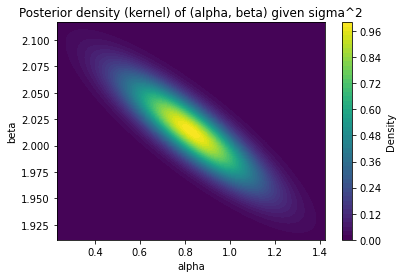

In [983]:
# Create a grid for alpha and beta
alpha_vals = np.linspace(theta_n[0] - 3*np.sqrt(Cov_n [0,0]), theta_n[0] + 3*np.sqrt(Cov_n [0,0]), 100)
beta_vals  = np.linspace(theta_n[1] - 3*np.sqrt(Cov_n [1,1]), theta_n[1] + 3*np.sqrt(Cov_n [1,1]), 100)
A, B = np.meshgrid(alpha_vals, beta_vals)

# Compute the (unnormalized) density of theta given sigma^2 (up to sigma^2 scaling)
# Here we ignore the sigma^2 integration and display the kernel of the Normal density.
# For each (alpha, beta) the kernel is: exp(-0.5*(theta - theta_n)^T Vn^{-1} (theta - theta_n))
inv_Vn = np.linalg.inv(Cov_n )
diff = np.array([A - theta_n[0], B - theta_n[1]])
exponent = -0.5 * (inv_Vn[0, 0]*diff[0]**2 + 2*inv_Vn[0, 1]*diff[0]*diff[1] + inv_Vn[1, 1]*diff[1]**2)
density = np.exp(exponent)

plt.contourf(A, B, density, levels=50, cmap='viridis')
plt.xlabel('alpha')
plt.ylabel('beta')
plt.title('Posterior density (kernel) of (alpha, beta) given sigma^2')
plt.colorbar(label='Density')
plt.show()